# Práctica 5: Clasificación bayesiana
### Autor: Daniel Herce Cruz, 848884
### Versión 1.0
### Fecha: 14-3-2024

---


## Configuración

In [1]:
%matplotlib inline
try:
  from google.colab import drive
  print("Trabajando en Colab") 
  drive.mount('/content/drive')                # Monta tu google drive
  Path = '/content/drive/MyDrive/Aprendizaje/' # Directorio donde guardas los ficheros
except:
  print("Trabajando en local")
  Path = ''                                    # Directorio donde guardas los ficheros

Trabajando en local


---
## 0. Visualización de datos

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

# Load data from https://www.openml.org/
dataset = "mnist_784"
X, y = fetch_openml(dataset, version=1, return_X_y=True, as_frame=False, parser="pandas")
X = X / 255.0  # Escalar los datos entre 0 y 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, shuffle=False)

print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)

# Mostramos la cantidad de datos por clase
print(pd.Series(y_train).value_counts().sort_index())

X_train.shape: (60000, 784)
y_train.shape: (60000,)
X_test.shape: (10000, 784)
y_test.shape: (10000,)
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64


## Métricas de evaluación

In [3]:
# Este método se utilizará a lo largo de la práctica
from sklearn.metrics import classification_report
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

results = pd.DataFrame() # Variable global para guardar la tabla de resultados

In [4]:
from sklearn.metrics import accuracy_score, f1_score
## Función para añadir las métricas de un modelo a la tabla de resultados
def addMetricsToResults(label, y_train, y_train_pred, y_test, y_test_pred, model = '-', train_time='-', results_var=None, displayMetric=True):
    """
    Función que añade las métricas de un modelo a la tabla de resultados global o 
    a la tabla que se le pase como argumento.

    Parámetros:
    - label: Etiqueta para identificar el modelo.
    - y_train: Valores reales del conjunto de entrenamiento.
    - y_train_pred: Valores predichos por el modelo para el conjunto de entrenamiento.
    - y_test: Valores reales del conjunto de prueba.
    - y_test_pred: Valores predichos por el modelo para el conjunto de prueba.
    - results_var: Tabla de resultados a la que añadir las métricas. Si no se pasa, se añaden a la tabla global.
    - displayMetric: Si es True, muestra las métricas por pantalla.

    Retorna:
    No retorna ningún valor, pero agrega una fila con las métricas calculadas a la tabla de resultados global.
    """
    global results
    
    next_res = pd.DataFrame(
        {"Label": label,
        "accuracy_train": accuracy_score(y_train, y_train_pred),
        "f1_train": f1_score(y_train, y_train_pred, average="weighted"), 
        # average="weighted" para que calcule la media pesada, es decir, que tenga en cuenta el desbalanceo de las clases
        'train_time': train_time,
        "model": model,
        "accuracy_test": accuracy_score(y_test, y_test_pred),
        "f1_test": f1_score(y_test, y_test_pred, average="weighted"),
        },
        
        index=[0]
    )
    
    if displayMetric:
        display(next_res)

    if results_var is not None:
        # Añadir la fila a la tabla de resultados, concat() devuelve una nueva tabla con la fila añadida
        results_var = pd.concat([results_var, next_res], ignore_index=True) #ignore_index=True para que el índice de las filas sea consecutivo y no repita valores, si es False (por defecto) el índice de las filas es el de los dataframes que se concatenanç
        return results_var
    else:
        results = pd.concat([results, next_res], ignore_index=True)

Como MNIST tiene una cantidad balanceada de datos de cada clase, se puede utilizar la accuracy como métrica de evaluación. Además se utilizará la matriz de confusión para visualizar el desempeño del modelo.

## Funciones de utilidad

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Referencia: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def show_confusion_matrix(y_test, y_pred_test):
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # disp.plot(cmap='Blues')
    disp.plot()
    plt.show()


# Código generado con GitHub Copilot
def show_fails(y_test, y_pred_test, X_test, n=4):
    """
    Muestra los n primeros fallos del modelo en un subplot
    """
    fails = np.where(y_test != y_pred_test)[0]
    fig, axs = plt.subplots(1, n, figsize=(20, 20))
    for i in range(n):
        idx = fails[i]
        img = X_test[idx].reshape(28, 28)
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(f'Pred: {y_pred_test[idx]} - Real: {y_test[idx]}')
        axs[i].axis('off')
    plt.show()

def plot_variances(clf):
    """
    Muestra un mapa de calor con las varianzas de las características de la primera clase
    """
    plt.figure(figsize=(18, 9))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(clf.var_[i].reshape(28, 28), cmap='hot')
        plt.axis('off')
    plt.show()

---
## 2. Bayes ingenuo

En este apartado programaremos el entrenamiento y clasificación multi-clase, usando Bayes ingenuo, buscando el mejor valor para la regularización.

### 2.1. Curvas de aprendizaje para Bayes ingenuo

Dibujamos las  curvas  de  aprendizaje  de  un  clasificador Bayesiano suponiendo independencia de los datos, variando en número de muestras de entrenamiento entre  el  10%  y  el  100%  de  las  disponibles.

[learning_curve] Training set sizes: [ 4800  9600 14400 19200 24000 28800 33600 38400 43200 48000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:  1.2min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  34 out of  50 | elapsed:  2.1min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.9min finished


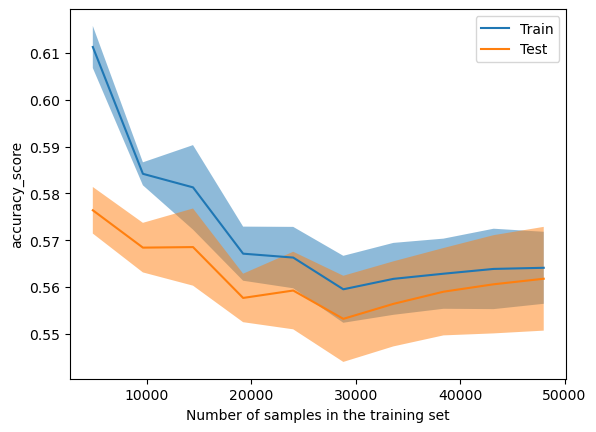

In [6]:
from sklearn.naive_bayes import GaussianNB
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
from sklearn.model_selection import LearningCurveDisplay
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LearningCurveDisplay.html
from sklearn.model_selection import learning_curve
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html


kfolds = 5
learning_sizes = 10
training_sizes = np.linspace(0.1, 1.0, learning_sizes)

# var_smoothing = 1e-9 (por defecto)
# priors = None (por defecto), las clases se ponderan según su frecuencia en el conjunto de entrenamiento
clfd = GaussianNB()
train_sizes_abs, train_acc, test_acc, fit_times, _ = learning_curve(
    clfd, X_train, y_train, cv=kfolds, n_jobs=-1, train_sizes=training_sizes, verbose=3, return_times=True, scoring='accuracy')

learning_curve_img = LearningCurveDisplay(train_sizes=train_sizes_abs, train_scores=train_acc, test_scores=test_acc, score_name='accuracy_score')
learning_curve_img.plot()

Replicamos lo anterior pero probando el efecto de inicializar las probabilidades a priori con valores uniformes, 0.1 cada clase en nuestro caso

[learning_curve] Training set sizes: [ 4800  9600 14400 19200 24000 28800 33600 38400 43200 48000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:  1.5min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  34 out of  50 | elapsed:  2.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.3min finished


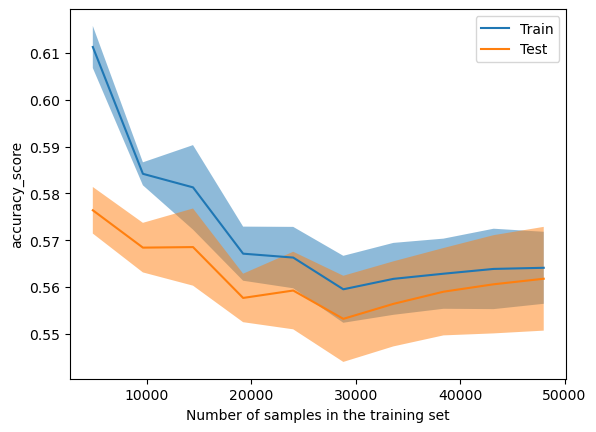

In [7]:
# Hacemos exactamente lo mismo pero con priors=[0.1]*10
clfp = GaussianNB(priors=[0.1]*10)
# Mostramos la curva de aprendizaje
train_sizes_abs, train_acc_p, test_acc_p, fit_times_p, _ = learning_curve(
    clfp, X_train, y_train, cv=kfolds, n_jobs=-1, train_sizes=training_sizes, verbose=3, return_times=True, scoring='accuracy')
# No me gusta este plot por que no se aprecia a que valores convergen las curvas
learning_curve_img = LearningCurveDisplay(train_sizes=train_sizes_abs, train_scores=train_acc, test_scores=test_acc, score_name='accuracy_score')
learning_curve_img.plot()

La precisión del clasificador Bayesiano ingenuo empeora a medida que aumenta el número de datos hasta el 60%, después de este punto la precisión aumenta ligeramente sin llegar a los niveles anteriores. Los valoeres de precisión entre los que se mueve son 0.58 y 0.55, lo que indica que la variación según el número de datos es baja a pesar de ser irregular.

### 2.2. Entrenamiento del modelo por defecto

In [8]:
# Entrenamos el modelo con todos los datos
t1 = time.time()
clfd.fit(X_train, y_train)
t2 = time.time()

,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,GaussianNB(default),0.5649,0.529334,1.841578,GaussianNB(),0.5558,0.517042


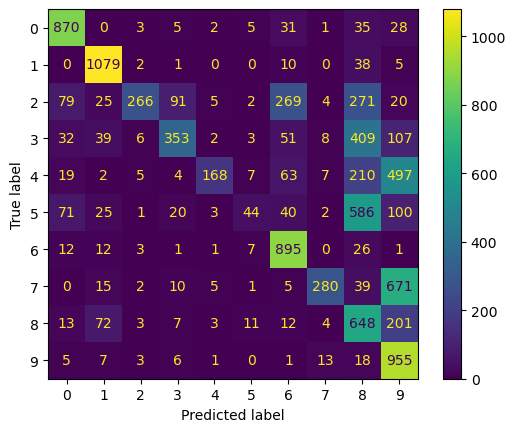

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       980
           1       0.85      0.95      0.90      1135
           2       0.90      0.26      0.40      1032
           3       0.71      0.35      0.47      1010
           4       0.88      0.17      0.29       982
           5       0.55      0.05      0.09       892
           6       0.65      0.93      0.77       958
           7       0.88      0.27      0.42      1028
           8       0.28      0.67      0.40       974
           9       0.37      0.95      0.53      1009

    accuracy                           0.56     10000
   macro avg       0.69      0.55      0.51     10000
weighted avg       0.69      0.56      0.52     10000



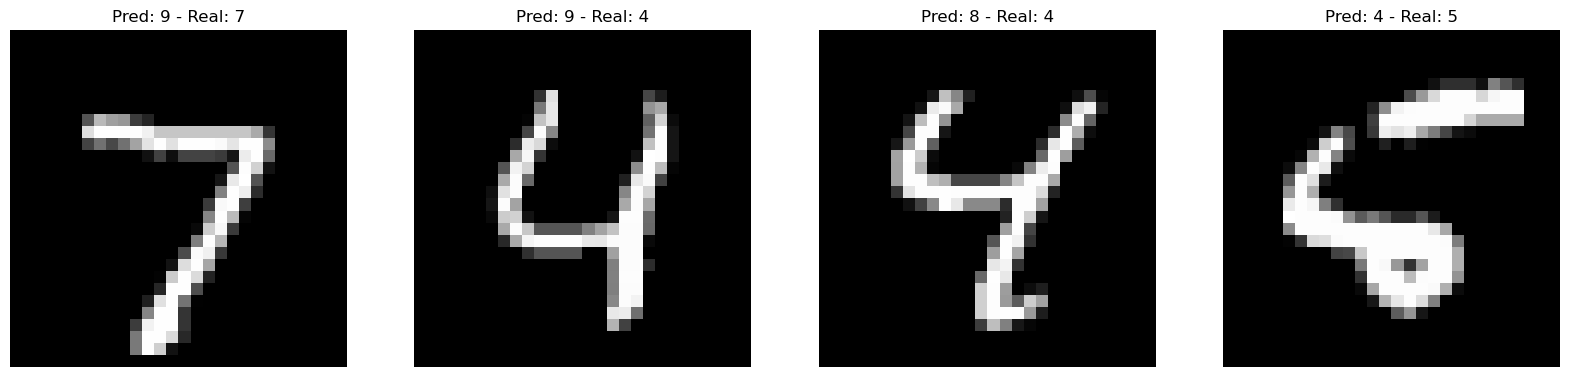

In [9]:
# Predecimos los valores de entrenamiento y prueba
y_train_pred = clfd.predict(X_train)
y_test_pred = clfd.predict(X_test)

# Añadimos las métricas a la tabla de resultados
addMetricsToResults("GaussianNB(default)", y_train, y_train_pred, y_test, y_test_pred, clfd, t2 - t1)
show_confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))
show_fails(y_test, y_test_pred, X_test)

In [10]:
# Entrenamos el modelo con todos los datos
t1 = time.time()
clfp.fit(X_train, y_train)
t2 = time.time()

,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,GaussianNB(priors=[0.10]*10),0.5649,0.529346,2.215322,"GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0....",0.5558,0.517075


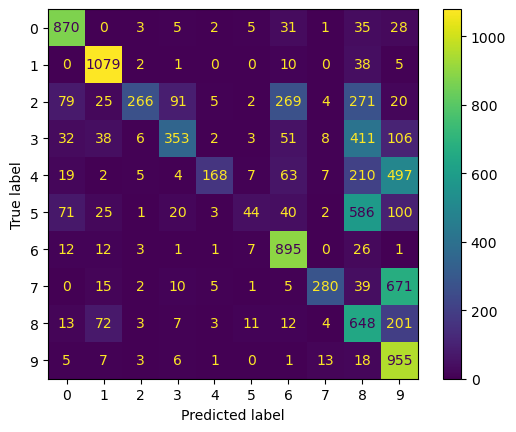

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       980
           1       0.85      0.95      0.90      1135
           2       0.90      0.26      0.40      1032
           3       0.71      0.35      0.47      1010
           4       0.88      0.17      0.29       982
           5       0.55      0.05      0.09       892
           6       0.65      0.93      0.77       958
           7       0.88      0.27      0.42      1028
           8       0.28      0.67      0.40       974
           9       0.37      0.95      0.53      1009

    accuracy                           0.56     10000
   macro avg       0.69      0.55      0.51     10000
weighted avg       0.69      0.56      0.52     10000



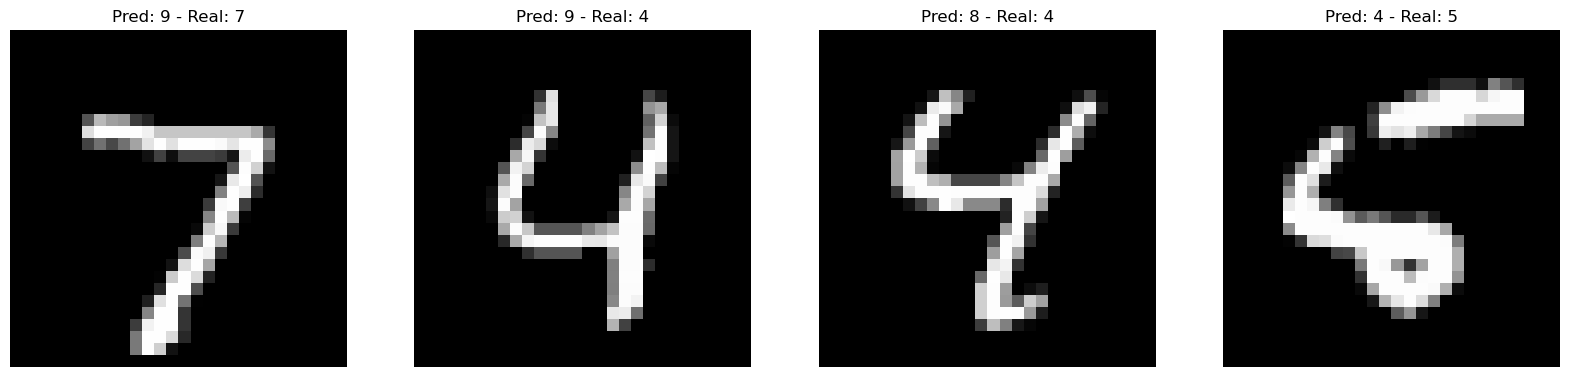

In [11]:
# Predecimos los valores de entrenamiento y prueba
y_train_pred = clfp.predict(X_train)
y_test_pred = clfp.predict(X_test)

# Añadimos las métricas a la tabla de resultados
addMetricsToResults("GaussianNB(priors=[0.10]*10)", y_train, y_train_pred, y_test, y_test_pred, clfp, t2 - t1)
show_confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))
show_fails(y_test, y_test_pred, X_test)

In [12]:
results

,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,GaussianNB(default),0.5649,0.529334,1.841578,GaussianNB(),0.5558,0.517042
1,GaussianNB(priors=[0.10]*10),0.5649,0.529346,2.215322,"GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0....",0.5558,0.517075


Este clasificador funciona muy mal, asume que las entradas no tienen relación entre ellas cuando claramente si que la tienen al ser píxeles de una foto. 

En cuanto a la comparación entre los dos clasificadores probados podemos observar que el indicar la probabilidad a priori no afecta en practicamente nada (tan solo en el quinto decimal del f1). Esto se debe a que aunque el segundo clasificador es alquel que supone una probabilidad inicial del 10% independientemente de que de algunos números hay más fotos no es mucho mejor que el por defecto ya que no hay una gran disparidad entre el número de fotos de cada clase.

Además, hay que ajustar la var_smoothing, aquí se ha utilizado el valor por defecto pero no espero que mejore mucho ajustándola ya que la premisa de bayes ingenuo es incorrecta.

### 2.3 Buscamos el mejor valor de regularización

A continuación intentaremos mejorar el modelo anterior encontrando un valor de regularización que mejore el desempeño del modelo.

var_smoothing lo que hace es añadir un valor pequeño a la diagonal de la matriz de covarianza para mejorar la estabilidad de los cálculos. Cuanto mayor sea el valor de var_smoothing mayor será la regularización.

In [13]:
train_f1 = []
train_acc = []
val_f1 = []
val_acc = []


var_smoothing_values   = np.logspace(-5, 1, 10)
print("var_smoothing_values:", var_smoothing_values)

var_smoothing_values: [1.00000000e-05 4.64158883e-05 2.15443469e-04 1.00000000e-03
 4.64158883e-03 2.15443469e-02 1.00000000e-01 4.64158883e-01
 2.15443469e+00 1.00000000e+01]


In [14]:
from sklearn.naive_bayes import GaussianNB
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
from sklearn.model_selection import cross_validate


for smooth_val in var_smoothing_values:
    print(f"Entrenando modelo con lambda={smooth_val}")
    clf = GaussianNB(priors=[0.1]*10, var_smoothing=smooth_val)

    scores = cross_validate(clf, X_train, y_train, cv=kfolds, return_train_score=True, scoring=['accuracy', 'f1_weighted'])

    train_f1.append(np.mean(scores['train_f1_weighted']))
    train_acc.append(np.mean(scores['train_accuracy']))
    val_f1.append(np.mean(scores['test_f1_weighted']))
    val_acc.append(np.mean(scores['test_accuracy']))

Entrenando modelo con lambda=1e-05


Entrenando modelo con lambda=4.641588833612782e-05
Entrenando modelo con lambda=0.00021544346900318823
Entrenando modelo con lambda=0.001
Entrenando modelo con lambda=0.004641588833612777
Entrenando modelo con lambda=0.021544346900318822
Entrenando modelo con lambda=0.1
Entrenando modelo con lambda=0.46415888336127725
Entrenando modelo con lambda=2.154434690031882
Entrenando modelo con lambda=10.0


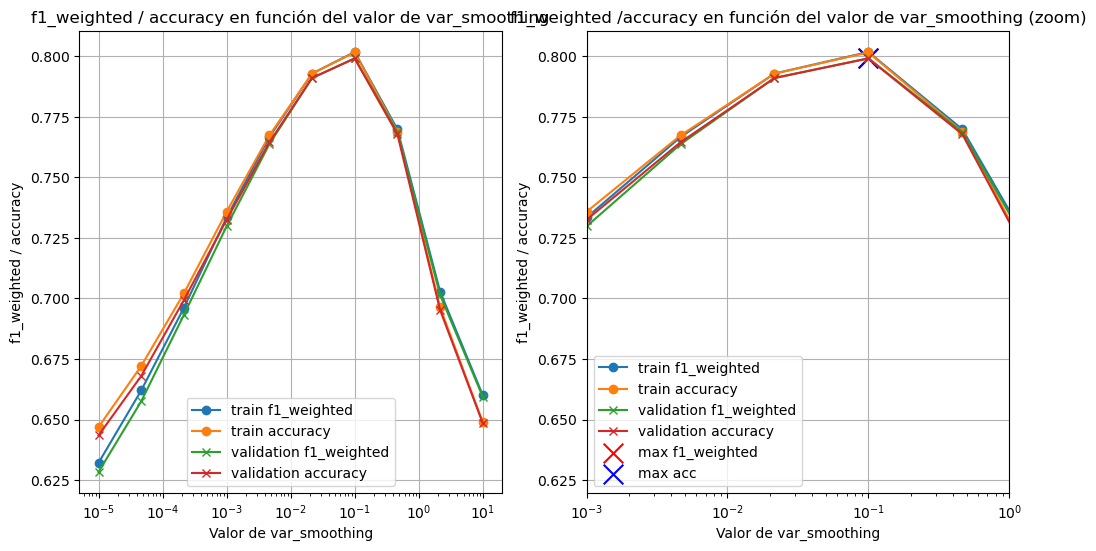

Valor de var_smoothing que maximiza el f1_weighted score: 0.1
f1_weighted máximo: 0.7991001799352382
Valor de var_smoothing que maximiza el accuracy: 0.1
accuracy máximo: 0.7990333333333334


In [15]:
# Mostramos la evolución de las métricas en función del valor de var_smoothing
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(var_smoothing_values, train_f1, label="train f1_weighted", marker='o')
ax[0].plot(var_smoothing_values, train_acc, label="train accuracy", marker='o')
ax[0].plot(var_smoothing_values, val_f1, label="validation f1_weighted", marker='x')
ax[0].plot(var_smoothing_values, val_acc, label="validation accuracy", marker='x')
ax[0].set_xlabel("Valor de var_smoothing")
ax[0].set_xscale("log")
ax[0].set_ylabel("f1_weighted / accuracy")
ax[0].set_title("f1_weighted / accuracy en función del valor de var_smoothing")
ax[0].legend()
ax[0].grid()

# Ahora mostraremos un zoom en la zona donde se encuentra el mínimo
ax[1].plot(var_smoothing_values, train_f1, label="train f1_weighted", marker='o')
ax[1].plot(var_smoothing_values, train_acc, label="train accuracy", marker='o')
ax[1].plot(var_smoothing_values, val_f1, label="validation f1_weighted", marker='x')
ax[1].plot(var_smoothing_values, val_acc, label="validation accuracy", marker='x')
ax[1].scatter(var_smoothing_values[np.argmax(val_f1)], max(val_f1), c='red', marker='x', label='max f1_weighted', s=200)
ax[1].scatter(var_smoothing_values[np.argmax(val_acc)], max(val_acc), c='blue', marker='x', label='max acc', s=200)
ax[1].set_xlabel("Valor de var_smoothing")
ax[1].set_xscale("log")
ax[1].set_ylabel("f1_weighted / accuracy")
ax[1].set_title("f1_weighted /accuracy en función del valor de var_smoothing (zoom)")
ax[1].legend()
ax[1].grid()
ax[1].set_xlim(1e-3, 1)
# ax[1].set_ylim(0.8, 1)
plt.show()

print("Valor de var_smoothing que maximiza el f1_weighted score:", var_smoothing_values[np.argmax(val_f1)])
print("f1_weighted máximo:", max(val_f1))
print("Valor de var_smoothing que maximiza el accuracy:", var_smoothing_values[np.argmax(val_acc)])
print("accuracy máximo:", max(val_acc))

El mejor valor de val_smoothing es 0.1, que es un valor relativamente alto (comparado con el 1e-9 que es por defecto). Esto tiene sentido ya que el clasificador bayesiano ingenuo no es el mejor modelo para MNIST, por lo que es necesario regularizarlo más para que funcione mejor.

### 2.4 Entrenamiento del mejor modelo

,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,GaussianNB(best_var_smoothing),0.801333,0.801512,0.503757,"GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0....",0.8141,0.814061


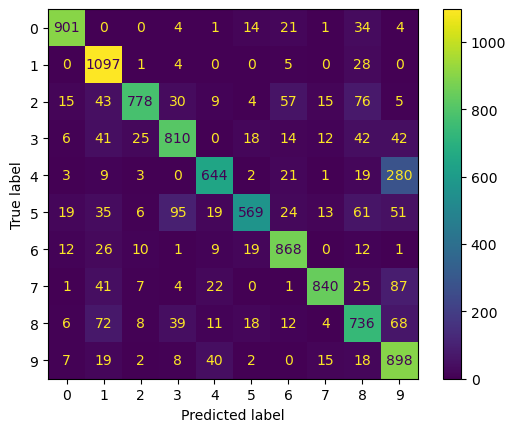

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       980
           1       0.79      0.97      0.87      1135
           2       0.93      0.75      0.83      1032
           3       0.81      0.80      0.81      1010
           4       0.85      0.66      0.74       982
           5       0.88      0.64      0.74       892
           6       0.85      0.91      0.88       958
           7       0.93      0.82      0.87      1028
           8       0.70      0.76      0.73       974
           9       0.63      0.89      0.73      1009

    accuracy                           0.81     10000
   macro avg       0.83      0.81      0.81     10000
weighted avg       0.83      0.81      0.81     10000



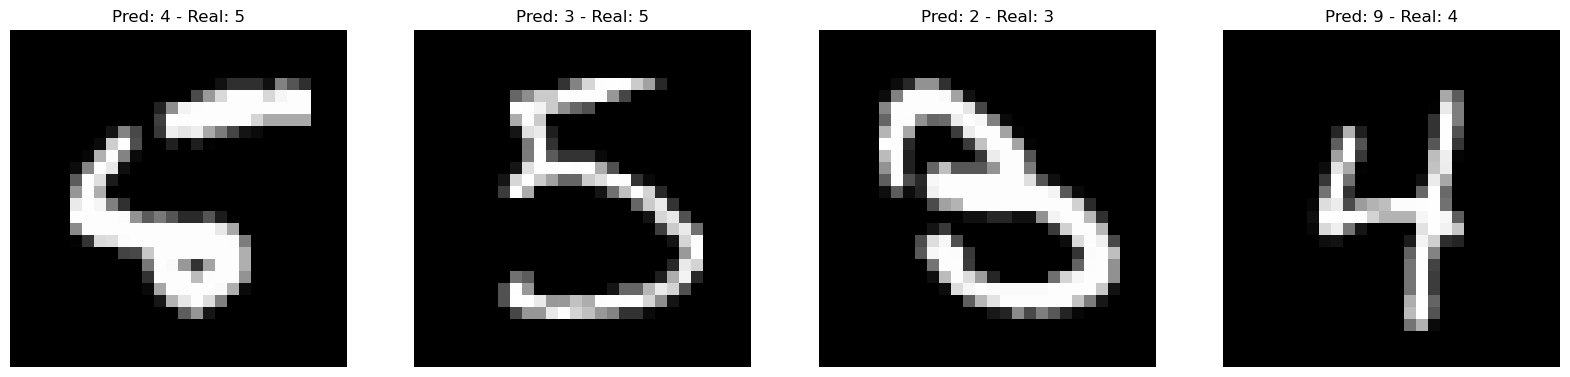

In [16]:
# Entrenamos el modelo con mejor lambda
clf = GaussianNB(priors=[0.1]*10, var_smoothing=var_smoothing_values[np.argmax(val_acc)])

t1 = time.time()
clf.fit(X_train, y_train)
t2 = time.time()

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

addMetricsToResults("GaussianNB(best_var_smoothing)", y_train, y_train_pred, y_test, y_test_pred, clf, t2 - t1)
show_confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

show_fails(y_test, y_test_pred, X_test)

### 2.5 Estudio de las varianzas

En Bayes ingenuo la matriz de covarianzas es diagonal, por lo que solo se almacenan las varianzas de cada característica para cada clase

(10, 784)


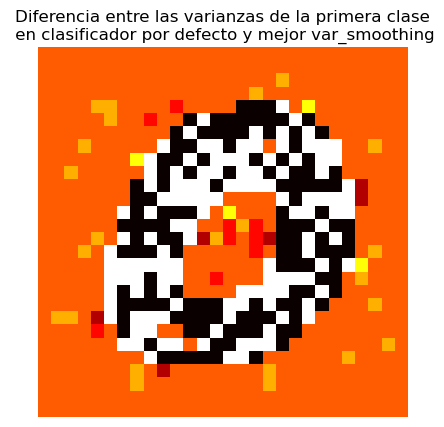

[0.01992066 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066
 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066
 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066
 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066
 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066
 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066
 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066
 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066
 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066
 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066
 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066
 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066
 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066
 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066
 0.01992066 0.01992066 0.01992066 0.01992066 0.01992066 0.0199

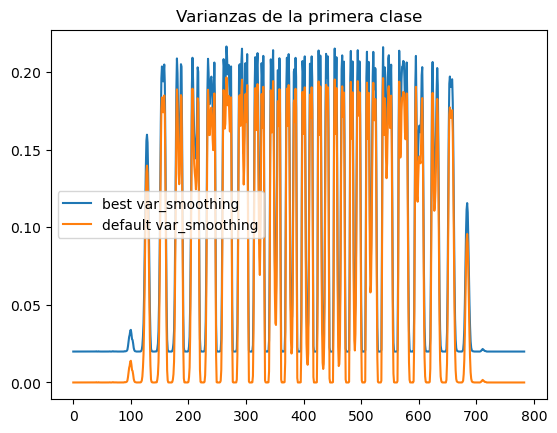

In [17]:

# En clf.var_ se muestran todas las varianzas de las características para cada clase
# display(clf.var_)
print(clf.var_.shape)

# Por curiosidad mostraremos la diferencia entre las diagonales de la matriz de covarianzas de la 
# primera clase del clasificador por defecto y del clasificador con el mejor valor de var_smoothings
plt.figure()
plt.imshow((clf.var_[0]-clfd.var_[0]).reshape(28, 28), cmap='hot')
plt.title("Diferencia entre las varianzas de la primera clase\n en clasificador por defecto y mejor var_smoothing")
plt.axis('off')
plt.show()
print(clf.var_[0]-clfd.var_[0])

# Mostramos las varianzas de la primera clase de ambos clasificadores
plt.figure()
plt.plot(clf.var_[0], label="best var_smoothing")
plt.plot(clfd.var_[0], label="default var_smoothing")
plt.title("Varianzas de la primera clase")
plt.legend()
plt.show()

Como podemos observar, al regularizar el modelo lo que se hace es aumentar ligeramente la varianza de las características, lo que hace que el modelo sea más robusto a pequeñas variaciones en los datos.

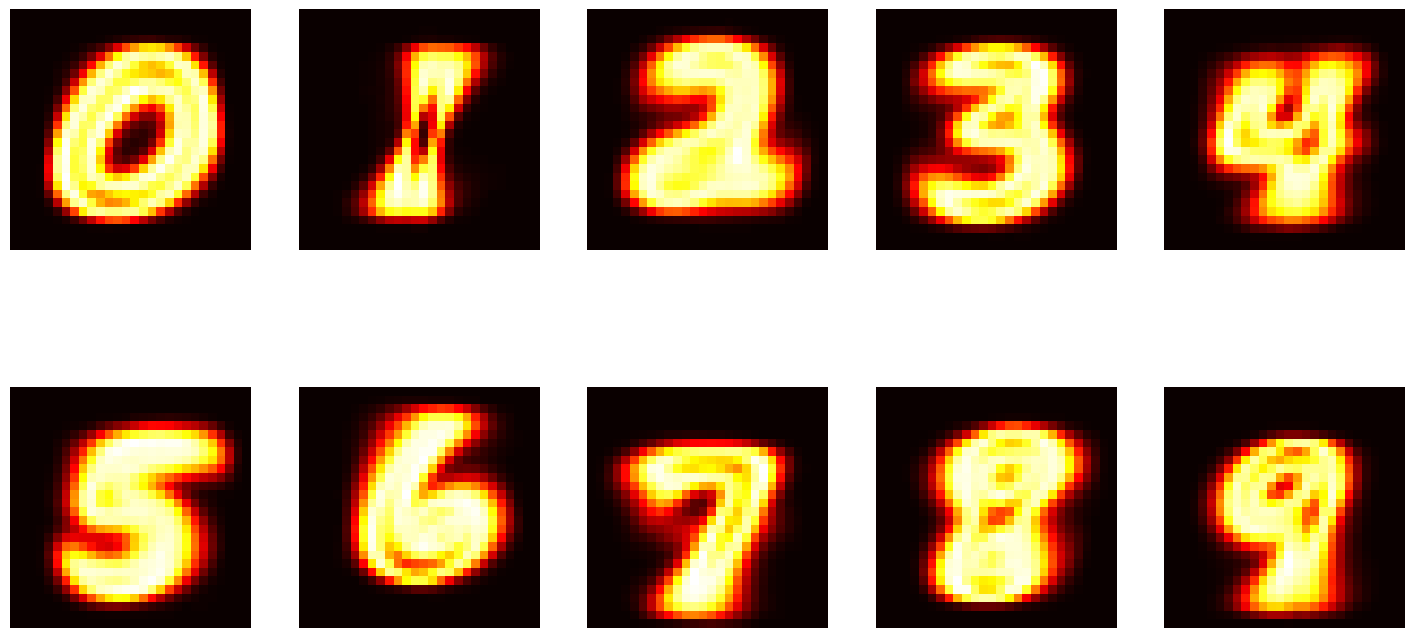

In [18]:
# Plot de un mapa de calor de 28 de alto por 28 de ancho con las varianzas de las características
# de la primera clase
plot_variances(clf)

Cuanto más intenso es el color significa que hay una mayor varianza en esa posición. Cuanto más oscuro significa que hay menos varianza. Los píxeles de los alrededores están oscuros porque nunca hay números en esos píxeles por lo que la varianza es siempre 0 o cercana a 0. En el centro se observa que están los píxeles más blancos, que son los que varían más su intensidad a lo largo de la clase. Esto tiene sentido ya que en el centro es donde se encuentra el número que se está representando y por lo tanto es donde más varía la intensidad de los píxeles.

### 2.5 Discusión de resultados

In [19]:
results

,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,GaussianNB(default),0.564900,0.529334,1.841578,GaussianNB(),0.5558,0.517042
1,GaussianNB(priors=[0.10]*10),0.564900,0.529346,2.215322,"GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0....",0.5558,0.517075
2,GaussianNB(best_var_smoothing),0.801333,0.801512,0.503757,"GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0....",0.8141,0.814061


Como podemos observar regularizar el modelo ha mejorado su desempeño considerablemente. Hemos observado como regularizar aumenta ligeramente las varianzas de las características, lo que hace que el modelo sea más robusto a pequeñas variaciones en los datos. Se ha realizado un estudio de las varianzas de este clasificador donde se ha podido observar que los píxeles que más varían son los que están en el centro de la imagen, lo que tiene sentido ya que es donde se encuentra el número que se está representando y por lo tanto es donde más varía la intensidad de los píxeles.

Este estudio se ha realizado aquí porque es donde más sentido tiene ya que se ha observado una diferencia muy notable, si la diferencia hubiera sido menor no habría sido interesante realizar este estudio.

---
## 3. Análisis discriminante lineal (LDA)

Repetimos el apartado anterior con un modelo de análisis discriminante lineal.
El modelo anterior con Bayes Ingenuo asume que todas las características son independientes, por lo que su matriz de covarianza es diagonal. En cambio, LDA asume que todas las clases comparten la misma matriz de covarianza, por lo que es un modelo más general que el anterior.

### 3.1. Curvas de aprendizaje

Dibujamos las  curvas  de  aprendizaje  de  un  clasificador Bayesiano  que ya no supone independencia de los datos aunque si que supone la misma covarianza entre todas las clases, variando en número de muestras de entrenamiento entre  el  10%  y  el  100%  de  las  disponibles.

[learning_curve] Training set sizes: [ 4800  9600 14400 19200 24000 28800 33600 38400 43200 48000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   33.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  34 out of  50 | elapsed:   59.8s remaining:   28.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


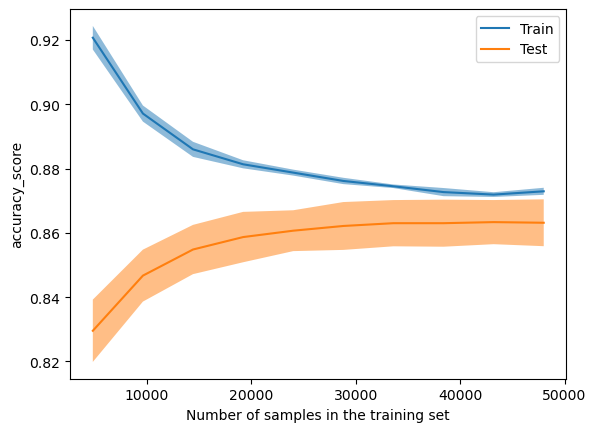

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

from sklearn.model_selection import LearningCurveDisplay
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LearningCurveDisplay.html
from sklearn.model_selection import learning_curve
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html


kfolds = 5
learning_sizes = 10
training_sizes = np.linspace(0.1, 1.0, learning_sizes)

# var_smoothing = 1e-9 (por defecto)
# priors = None (por defecto), las clases se ponderan según su frecuencia en el conjunto de entrenamiento
clfd = LinearDiscriminantAnalysis()
train_sizes_abs, train_acc, test_acc, fit_times, _ = learning_curve(
    clfd, X_train, y_train, cv=kfolds, n_jobs=-1, train_sizes=training_sizes, verbose=3, return_times=True, scoring='accuracy')

learning_curve_img = LearningCurveDisplay(train_sizes=train_sizes_abs, train_scores=train_acc, test_scores=test_acc, score_name='accuracy_score')
learning_curve_img.plot()

### 3.2. Entrenamiento del modelo por defecto

In [21]:
# Entrenamos el modelo con todos los datos
t1 = time.time()
clfd.fit(X_train, y_train)
t2 = time.time()

,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,LinearDiscriminantAnalysis(default),0.871483,0.871465,3.360857,LinearDiscriminantAnalysis(),0.873,0.872678


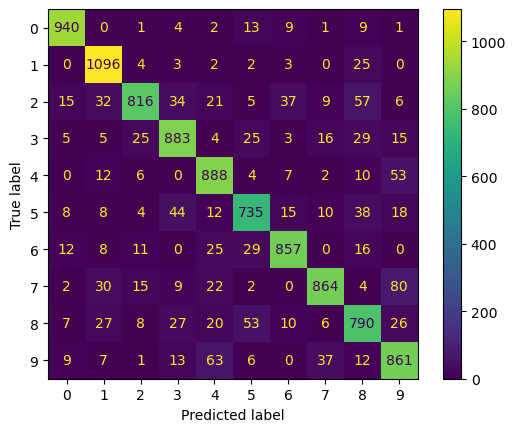

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.89      0.97      0.93      1135
           2       0.92      0.79      0.85      1032
           3       0.87      0.87      0.87      1010
           4       0.84      0.90      0.87       982
           5       0.84      0.82      0.83       892
           6       0.91      0.89      0.90       958
           7       0.91      0.84      0.88      1028
           8       0.80      0.81      0.80       974
           9       0.81      0.85      0.83      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



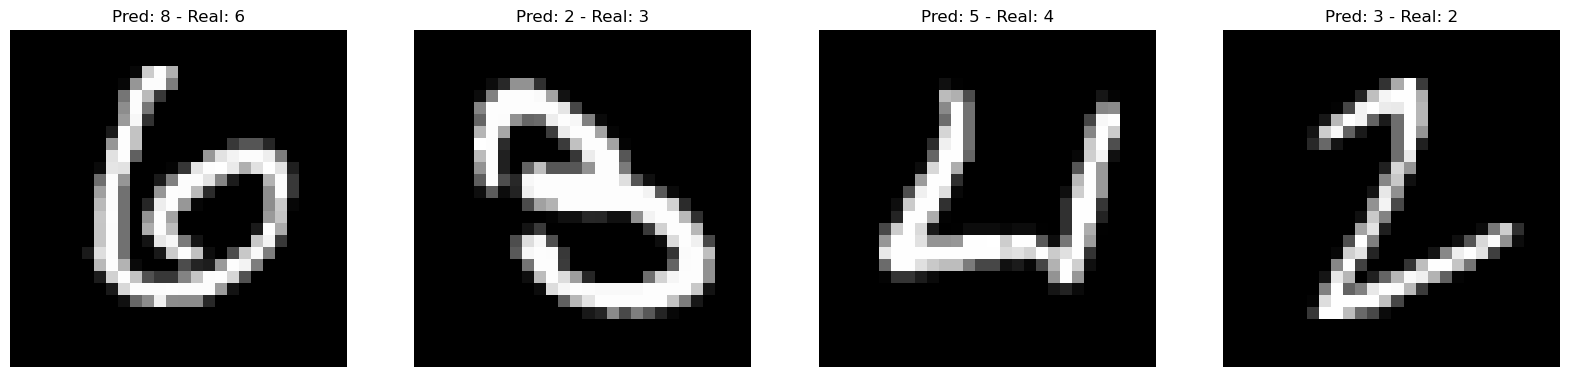

In [22]:
# Predecimos los valores de entrenamiento y prueba
y_train_pred = clfd.predict(X_train)
y_test_pred = clfd.predict(X_test)

# Añadimos las métricas a la tabla de resultados
addMetricsToResults("LinearDiscriminantAnalysis(default)", y_train, y_train_pred, y_test, y_test_pred, clfd, t2 - t1)
show_confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))
show_fails(y_test, y_test_pred, X_test)

In [23]:
results

,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,GaussianNB(default),0.564900,0.529334,1.841578,GaussianNB(),0.5558,0.517042
1,GaussianNB(priors=[0.10]*10),0.564900,0.529346,2.215322,"GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0....",0.5558,0.517075
2,GaussianNB(best_var_smoothing),0.801333,0.801512,0.503757,"GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0....",0.8141,0.814061
3,LinearDiscriminantAnalysis(default),0.871483,0.871465,3.360857,LinearDiscriminantAnalysis(),0.8730,0.872678


Este clasificador funciona mucho mejor que el anterior aún estando con todos los parámetros por defecto, ya que asume que las características no son independientes entre ellas aunque si que asume que todas las covarianzas entre los atributos son iguales para todas las clases. A continuación buscaremos el mejor solver y valor de regularización.

### 3.3. Buscamos el mejor solver

In [24]:
resultsSolver = pd.DataFrame()
solvers = ['lsqr', 'eigen'] # 'svd' es el solver por defecto

# lsqr: Least Squares solution, funciona bien con pocas muestras y muchas características
# eigen: Eigenvalue decomposition, funciona bien con pocas características y muchas muestras
for solver in solvers:
    print(f"Entrenando modelo con solver={solver}")
    clf = LinearDiscriminantAnalysis(solver=solver, shrinkage='auto')

    t1 = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    resultsSolver = addMetricsToResults(f"LinearDiscriminantAnalysis({solver})", y_train, y_train_pred, y_test, y_test_pred, clf, t2 - t1, resultsSolver, False)

resultsSolver


Entrenando modelo con solver=lsqr
Entrenando modelo con solver=eigen


,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,LinearDiscriminantAnalysis(lsqr),0.875483,0.875476,2.010324,"LinearDiscriminantAnalysis(shrinkage='auto', s...",0.8781,0.877792
1,LinearDiscriminantAnalysis(eigen),0.875483,0.875476,3.198628,"LinearDiscriminantAnalysis(shrinkage='auto', s...",0.8781,0.877792


Como podemos observar ambos modelos se comportan igual, sin embargo el solver 'lsqr' es más rápido que el 'eigen' por lo que lo utilizaremos.

,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,"LinearDiscriminantAnalysis(lsqr, shrinkage='au...",0.875483,0.875476,2.014574,"LinearDiscriminantAnalysis(shrinkage='auto', s...",0.8781,0.877792


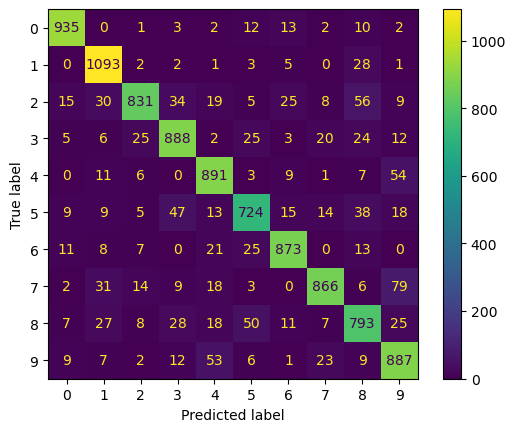

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       980
           1       0.89      0.96      0.93      1135
           2       0.92      0.81      0.86      1032
           3       0.87      0.88      0.87      1010
           4       0.86      0.91      0.88       982
           5       0.85      0.81      0.83       892
           6       0.91      0.91      0.91       958
           7       0.92      0.84      0.88      1028
           8       0.81      0.81      0.81       974
           9       0.82      0.88      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [25]:
clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

t1 = time.time()
clf.fit(X_train, y_train)
t2 = time.time()

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

addMetricsToResults(f"LinearDiscriminantAnalysis(lsqr, shrinkage='auto')", y_train, y_train_pred, y_test, y_test_pred, clf, t2 - t1)
show_confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

### 3.4 Buscamos el mejor valor de regularización

A continuación intentaremos mejorar el modelo anterior encontrando un valor de regularización que mejore el desempeño del modelo.

var_smoothing lo que hace es añadir un valor pequeño a la diagonal de la matriz de covarianza para mejorar la estabilidad de los cálculos. Cuanto mayor sea el valor de var_smoothing mayor será la regularización.

In [26]:
train_f1 = []
train_acc = []
val_f1 = []
val_acc = []


shrinkage_values   = np.logspace(-5, 0, 10)
print("shrinkage_values:", shrinkage_values)

shrinkage_values: [1.00000000e-05 3.59381366e-05 1.29154967e-04 4.64158883e-04
 1.66810054e-03 5.99484250e-03 2.15443469e-02 7.74263683e-02
 2.78255940e-01 1.00000000e+00]


In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate


for shrinkage_val in shrinkage_values:
    print(f"Entrenando modelo con shrinkage={shrinkage_val}")
    clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=shrinkage_val)

    scores = cross_validate(clf, X_train, y_train, cv=kfolds, return_train_score=True, scoring=['accuracy', 'f1_weighted'])

    train_f1.append(np.mean(scores['train_f1_weighted']))
    train_acc.append(np.mean(scores['train_accuracy']))
    val_f1.append(np.mean(scores['test_f1_weighted']))
    val_acc.append(np.mean(scores['test_accuracy']))

Entrenando modelo con shrinkage=1e-05


Entrenando modelo con shrinkage=3.5938136638046256e-05
Entrenando modelo con shrinkage=0.0001291549665014884
Entrenando modelo con shrinkage=0.0004641588833612782
Entrenando modelo con shrinkage=0.0016681005372000592
Entrenando modelo con shrinkage=0.005994842503189409
Entrenando modelo con shrinkage=0.021544346900318846
Entrenando modelo con shrinkage=0.07742636826811278
Entrenando modelo con shrinkage=0.2782559402207126
Entrenando modelo con shrinkage=1.0


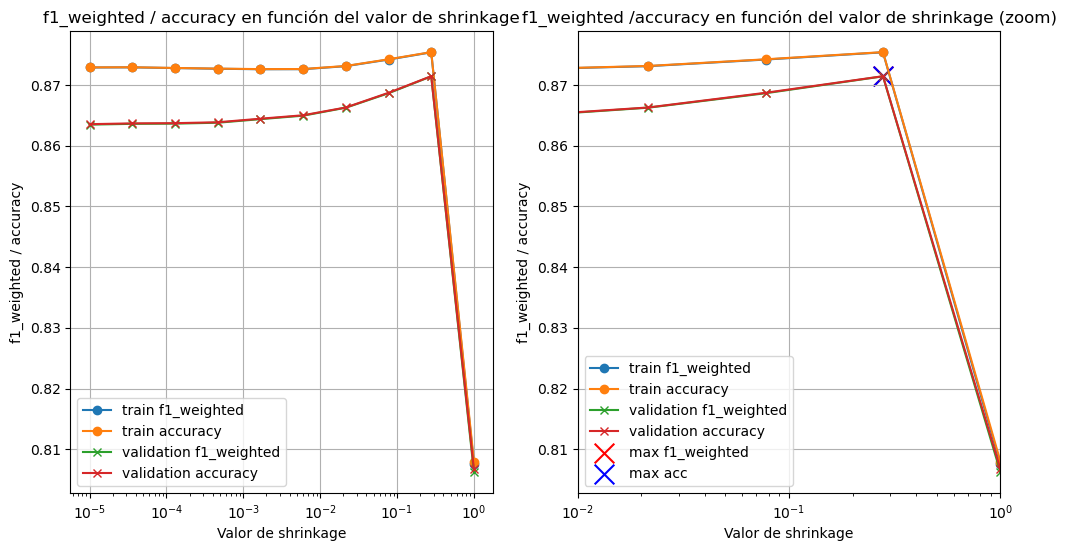

Valor de shrinkage que maximiza el f1_weighted score: 0.2782559402207126
f1_weighted máximo: 0.8713909905983857
Valor de shrinkage que maximiza el accuracy: 0.2782559402207126
accuracy máximo: 0.8714166666666667


In [28]:
# Mostramos la evolución de las métricas en función del valor de shrinkage
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(shrinkage_values, train_f1, label="train f1_weighted", marker='o')
ax[0].plot(shrinkage_values, train_acc, label="train accuracy", marker='o')
ax[0].plot(shrinkage_values, val_f1, label="validation f1_weighted", marker='x')
ax[0].plot(shrinkage_values, val_acc, label="validation accuracy", marker='x')
ax[0].set_xlabel("Valor de shrinkage")
ax[0].set_xscale("log")
ax[0].set_ylabel("f1_weighted / accuracy")
ax[0].set_title("f1_weighted / accuracy en función del valor de shrinkage")
ax[0].legend()
ax[0].grid()

# Ahora mostraremos un zoom en la zona donde se encuentra el mínimo
ax[1].plot(shrinkage_values, train_f1, label="train f1_weighted", marker='o')
ax[1].plot(shrinkage_values, train_acc, label="train accuracy", marker='o')
ax[1].plot(shrinkage_values, val_f1, label="validation f1_weighted", marker='x')
ax[1].plot(shrinkage_values, val_acc, label="validation accuracy", marker='x')
ax[1].scatter(shrinkage_values[np.argmax(val_f1)], max(val_f1), c='red', marker='x', label='max f1_weighted', s=200)
ax[1].scatter(shrinkage_values[np.argmax(val_acc)], max(val_acc), c='blue', marker='x', label='max acc', s=200)
ax[1].set_xlabel("Valor de shrinkage")
ax[1].set_xscale("log")
ax[1].set_ylabel("f1_weighted / accuracy")
ax[1].set_title("f1_weighted /accuracy en función del valor de shrinkage (zoom)")
ax[1].legend()
ax[1].grid()
ax[1].set_xlim(1e-2, 1)
# ax[1].set_ylim(0.8, 1)
plt.show()

print("Valor de shrinkage que maximiza el f1_weighted score:", shrinkage_values[np.argmax(val_f1)])
print("f1_weighted máximo:", max(val_f1))
print("Valor de shrinkage que maximiza el accuracy:", shrinkage_values[np.argmax(val_acc)])
print("accuracy máximo:", max(val_acc))

El shrinkage es un valor que se utiliza para regularizar la matriz de covarianza, si es 0 no se regulariza, si es 1 se regulariza al máximo. En este caso cuanto mayor es el valor del shrinkage mejor es el modelo hasta que llega en torno a 0.30 donde empieza a subajustarse.

Es notable que la regularización no mejora mucho el modelo. Esto puede deberse a que el modelo LDA por defecto ya es bastante bueno y no necesita regularización.

### 3.5 Entrenamiento del mejor modelo

,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,"LinearDiscriminantAnalysis(lsqr,best_shrinkage)",0.874883,0.874858,0.951229,LinearDiscriminantAnalysis(shrinkage=0.2782559...,0.8793,0.879036


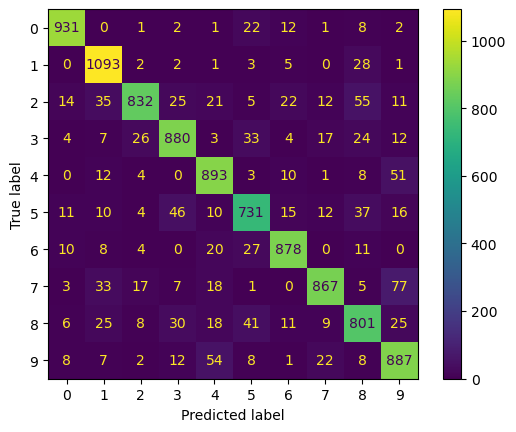

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       980
           1       0.89      0.96      0.92      1135
           2       0.92      0.81      0.86      1032
           3       0.88      0.87      0.87      1010
           4       0.86      0.91      0.88       982
           5       0.84      0.82      0.83       892
           6       0.92      0.92      0.92       958
           7       0.92      0.84      0.88      1028
           8       0.81      0.82      0.82       974
           9       0.82      0.88      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



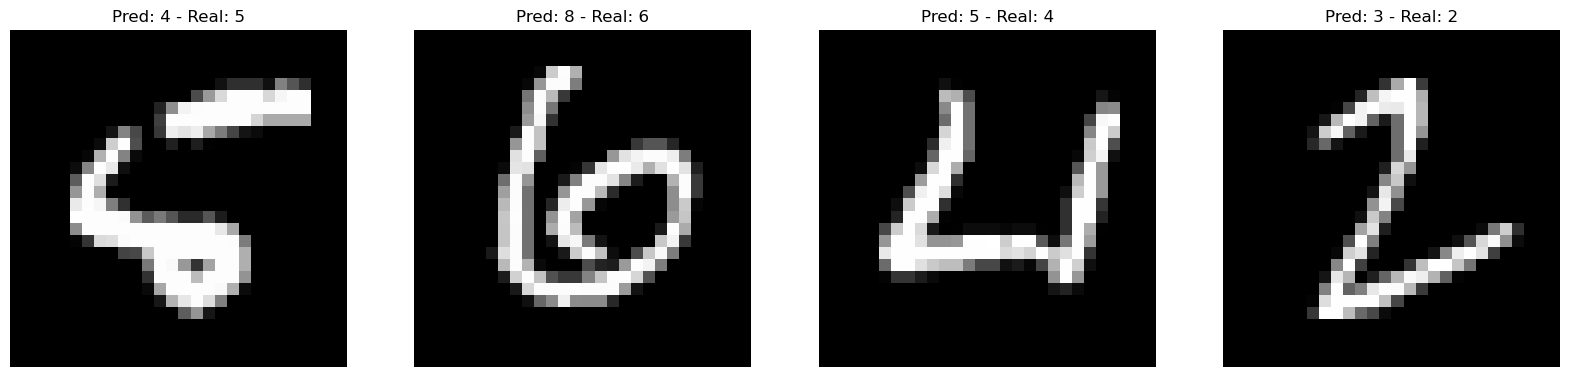

In [29]:
# Entrenamos el modelo con mejor lambda
clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=shrinkage_values[np.argmax(val_acc)])

t1 = time.time()
clf.fit(X_train, y_train)
t2 = time.time()

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

addMetricsToResults("LinearDiscriminantAnalysis(lsqr,best_shrinkage)", y_train, y_train_pred, y_test, y_test_pred, clf, t2 - t1)
show_confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

show_fails(y_test, y_test_pred, X_test)

In [30]:
results

,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,GaussianNB(default),0.564900,0.529334,1.841578,GaussianNB(),0.5558,0.517042
1,GaussianNB(priors=[0.10]*10),0.564900,0.529346,2.215322,"GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0....",0.5558,0.517075
2,GaussianNB(best_var_smoothing),0.801333,0.801512,0.503757,"GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0....",0.8141,0.814061
3,LinearDiscriminantAnalysis(default),0.871483,0.871465,3.360857,LinearDiscriminantAnalysis(),0.8730,0.872678
4,"LinearDiscriminantAnalysis(lsqr, shrinkage='au...",0.875483,0.875476,2.014574,"LinearDiscriminantAnalysis(shrinkage='auto', s...",0.8781,0.877792
5,"LinearDiscriminantAnalysis(lsqr,best_shrinkage)",0.874883,0.874858,0.951229,LinearDiscriminantAnalysis(shrinkage=0.2782559...,0.8793,0.879036


Se ha conseguido mejorar minimamente el modelo anterior poniendo el valor de regularización que mejor resultado a dado en lugar de dejarlo en 'auto'.

### 3.6. Probamos el estimador con covariance_estimator

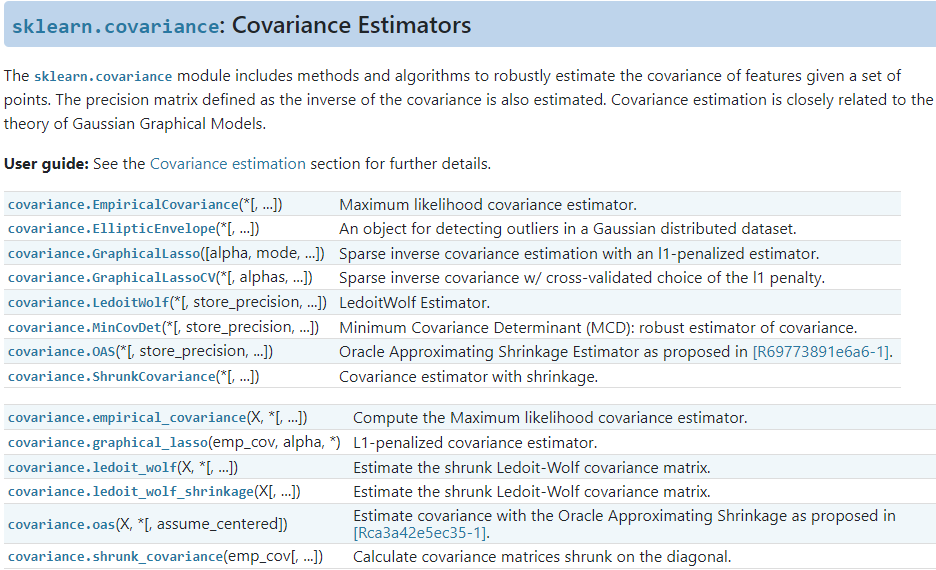

Referencia:https://scikit-learn.org/stable/modules/classes.html#module-sklearn.covariance

In [31]:
from sklearn.covariance import EmpiricalCovariance, LedoitWolf, OAS, ShrunkCovariance
# Referencia: https://scikit-learn.org/stable/modules/covariance.html

# MinCovDet no está pensado para ser usado con datos multiclase por lo que no lo vamos a usar

In [32]:
covariance_estimators = [EmpiricalCovariance(), LedoitWolf(), OAS(), ShrunkCovariance()]
covariance_labels = ['EmpiricalCovariance', 'LedoitWolf', 'OAS', 'ShrunkCovariance']

resultsCov = pd.DataFrame()
for cov, label in zip(covariance_estimators, covariance_labels):
    print(f"Entrenando modelo con {label}")
    clf = LinearDiscriminantAnalysis(solver='lsqr', covariance_estimator=cov)

    t1 = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    resultsCov = addMetricsToResults(f"LinearDiscriminantAnalysis(lsqr, {label})", y_train, y_train_pred, y_test, y_test_pred, clf, t2 - t1, resultsCov, False)

resultsCov

Entrenando modelo con EmpiricalCovariance


Entrenando modelo con LedoitWolf
Entrenando modelo con OAS
Entrenando modelo con ShrunkCovariance


,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,"LinearDiscriminantAnalysis(lsqr, EmpiricalCova...",0.871483,0.871465,1.963125,LinearDiscriminantAnalysis(covariance_estimato...,0.8730,0.872678
1,"LinearDiscriminantAnalysis(lsqr, LedoitWolf)",0.871417,0.871388,2.452855,LinearDiscriminantAnalysis(covariance_estimato...,0.8741,0.873810
2,"LinearDiscriminantAnalysis(lsqr, OAS)",0.871400,0.871371,2.013280,LinearDiscriminantAnalysis(covariance_estimato...,0.8741,0.873810
3,"LinearDiscriminantAnalysis(lsqr, ShrunkCovaria...",0.873567,0.873501,2.023452,LinearDiscriminantAnalysis(covariance_estimato...,0.8765,0.876186


,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,"LinearDiscriminantAnalysis(lsqr, ShrunkCovaria...",0.873567,0.873501,2.032893,LinearDiscriminantAnalysis(covariance_estimato...,0.8765,0.876186


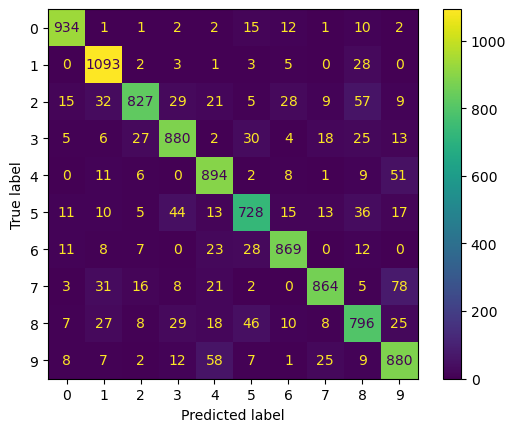

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       980
           1       0.89      0.96      0.93      1135
           2       0.92      0.80      0.86      1032
           3       0.87      0.87      0.87      1010
           4       0.85      0.91      0.88       982
           5       0.84      0.82      0.83       892
           6       0.91      0.91      0.91       958
           7       0.92      0.84      0.88      1028
           8       0.81      0.82      0.81       974
           9       0.82      0.87      0.84      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [33]:
# Añadimos a results el modelo con mejor cov_estimator
clf = LinearDiscriminantAnalysis(solver='lsqr', covariance_estimator=ShrunkCovariance())

t1 = time.time()
clf.fit(X_train, y_train)
t2 = time.time()

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

addMetricsToResults("LinearDiscriminantAnalysis(lsqr, ShrunkCovariance)", y_train, y_train_pred, y_test, y_test_pred, clf, t2 - t1)
show_confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))


### 3.7 Discusión de resultados

In [34]:
display(resultsCov)
results

,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,"LinearDiscriminantAnalysis(lsqr, EmpiricalCova...",0.871483,0.871465,1.963125,LinearDiscriminantAnalysis(covariance_estimato...,0.8730,0.872678
1,"LinearDiscriminantAnalysis(lsqr, LedoitWolf)",0.871417,0.871388,2.452855,LinearDiscriminantAnalysis(covariance_estimato...,0.8741,0.873810
2,"LinearDiscriminantAnalysis(lsqr, OAS)",0.871400,0.871371,2.013280,LinearDiscriminantAnalysis(covariance_estimato...,0.8741,0.873810
3,"LinearDiscriminantAnalysis(lsqr, ShrunkCovaria...",0.873567,0.873501,2.023452,LinearDiscriminantAnalysis(covariance_estimato...,0.8765,0.876186


,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,GaussianNB(default),0.564900,0.529334,1.841578,GaussianNB(),0.5558,0.517042
1,GaussianNB(priors=[0.10]*10),0.564900,0.529346,2.215322,"GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0....",0.5558,0.517075
2,GaussianNB(best_var_smoothing),0.801333,0.801512,0.503757,"GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0....",0.8141,0.814061
3,LinearDiscriminantAnalysis(default),0.871483,0.871465,3.360857,LinearDiscriminantAnalysis(),0.8730,0.872678
4,"LinearDiscriminantAnalysis(lsqr, shrinkage='au...",0.875483,0.875476,2.014574,"LinearDiscriminantAnalysis(shrinkage='auto', s...",0.8781,0.877792
5,"LinearDiscriminantAnalysis(lsqr,best_shrinkage)",0.874883,0.874858,0.951229,LinearDiscriminantAnalysis(shrinkage=0.2782559...,0.8793,0.879036
6,"LinearDiscriminantAnalysis(lsqr, ShrunkCovaria...",0.873567,0.873501,2.032893,LinearDiscriminantAnalysis(covariance_estimato...,0.8765,0.876186


Como podemos observar la suposición de que los datos no son independientes entre ellos ha mejorado el modelo, sin embargo, la suposición de que todas las clases comparten la misma matriz de covarianza no es cierta, por lo que el modelo aún puede mejorar. 

Además se ha comprobado que el solver 'lsqr' es más rápido que 'eigen' y se ha observado que las implementaciones donde se ha ajustado el valor de regularización son ligeramente mejores que las implementaciones donde se ha utilizado un covarianza_estimator por defecto. Esto se puede deber a que no se ha profundizado en el ajuste de los parámetros de covarianza_estimator, por lo que es posible que se pueda mejorar el modelo ajustando estos parámetros, sin embargo no se dispone de la experiencia necesaria para hacerlo en este momento.

---
## 4. Análisis discriminante cuadrático (QDA)

A continuación repetiremos el apartado anterior con un modelo de análisis discriminante cuadrático.
Este modelo es más general que el anterior, ya que asume que cada clase tiene su propia matriz de covarianza.

### 4.1. Curvas de aprendizaje

[learning_curve] Training set sizes: [ 4800  9600 14400 19200 24000 28800 33600 38400 43200 48000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   52.8s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  34 out of  50 | elapsed:  1.6min remaining:   44.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.2min finished


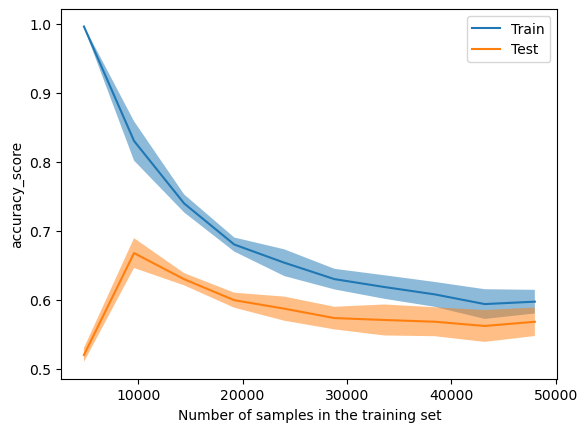

In [35]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html
from sklearn.model_selection import LearningCurveDisplay
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LearningCurveDisplay.html
from sklearn.model_selection import learning_curve
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html


kfolds = 5
learning_sizes = 10
training_sizes = np.linspace(0.1, 1.0, learning_sizes)

# reg_param = 0.0 (por defecto)
clfd = QuadraticDiscriminantAnalysis()
train_sizes_abs, train_acc, test_acc, fit_times, _ = learning_curve(
    clfd, X_train, y_train, cv=kfolds, n_jobs=-1, train_sizes=training_sizes, verbose=3, return_times=True, scoring='accuracy')

learning_curve_img = LearningCurveDisplay(train_sizes=train_sizes_abs, train_scores=train_acc, test_scores=test_acc, score_name='accuracy_score')
learning_curve_img.plot()

Llama la atención que este modelo se comporta como el modelo de Bayes Ingenuo. El valor por defecto de la regularización es 0.0 

### 4.2. Entrenamiento del modelo por defecto

In [36]:
# Entrenamos el modelo con todos los datos
t1 = time.time()
clfd.fit(X_train, y_train)
t2 = time.time()

c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,QuadraticDiscriminantAnalysis(default),0.5525,0.490568,4.150234,QuadraticDiscriminantAnalysis(),0.526,0.458334


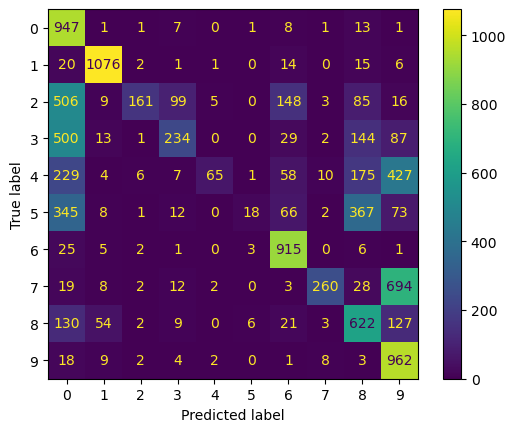

              precision    recall  f1-score   support

           0       0.35      0.97      0.51       980
           1       0.91      0.95      0.93      1135
           2       0.89      0.16      0.27      1032
           3       0.61      0.23      0.34      1010
           4       0.87      0.07      0.12       982
           5       0.62      0.02      0.04       892
           6       0.72      0.96      0.82       958
           7       0.90      0.25      0.39      1028
           8       0.43      0.64      0.51       974
           9       0.40      0.95      0.57      1009

    accuracy                           0.53     10000
   macro avg       0.67      0.52      0.45     10000
weighted avg       0.67      0.53      0.46     10000



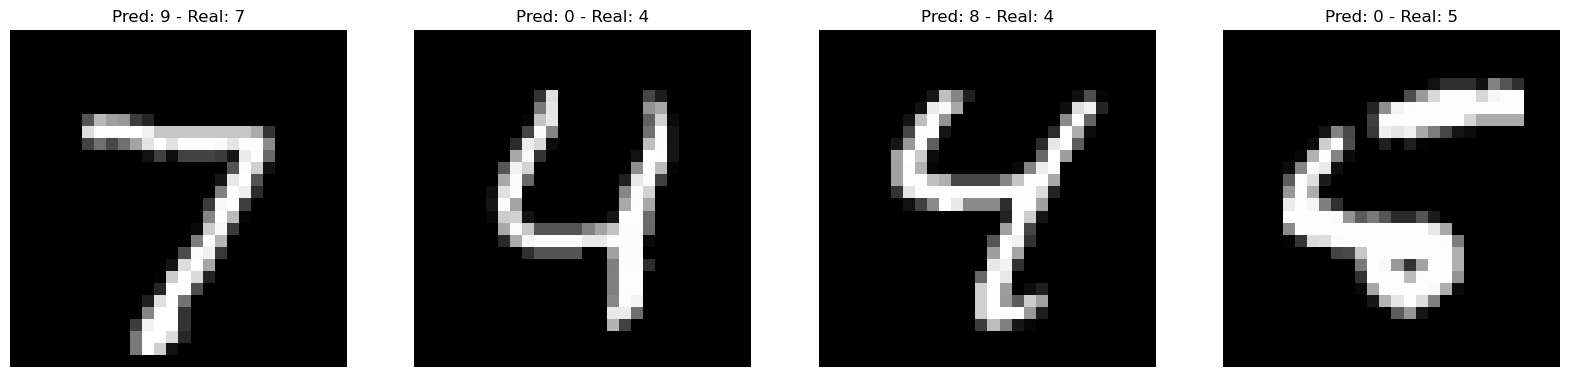

In [37]:
# Predecimos los valores de entrenamiento y prueba
y_train_pred = clfd.predict(X_train)
y_test_pred = clfd.predict(X_test)

# Añadimos las métricas a la tabla de resultados
addMetricsToResults("QuadraticDiscriminantAnalysis(default)", y_train, y_train_pred, y_test, y_test_pred, clfd, t2 - t1)
show_confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))
show_fails(y_test, y_test_pred, X_test)

In [38]:
results

,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,GaussianNB(default),0.564900,0.529334,1.841578,GaussianNB(),0.5558,0.517042
1,GaussianNB(priors=[0.10]*10),0.564900,0.529346,2.215322,"GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0....",0.5558,0.517075
2,GaussianNB(best_var_smoothing),0.801333,0.801512,0.503757,"GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0....",0.8141,0.814061
3,LinearDiscriminantAnalysis(default),0.871483,0.871465,3.360857,LinearDiscriminantAnalysis(),0.8730,0.872678
4,"LinearDiscriminantAnalysis(lsqr, shrinkage='au...",0.875483,0.875476,2.014574,"LinearDiscriminantAnalysis(shrinkage='auto', s...",0.8781,0.877792
5,"LinearDiscriminantAnalysis(lsqr,best_shrinkage)",0.874883,0.874858,0.951229,LinearDiscriminantAnalysis(shrinkage=0.2782559...,0.8793,0.879036
6,"LinearDiscriminantAnalysis(lsqr, ShrunkCovaria...",0.873567,0.873501,2.032893,LinearDiscriminantAnalysis(covariance_estimato...,0.8765,0.876186
7,QuadraticDiscriminantAnalysis(default),0.552500,0.490568,4.150234,QuadraticDiscriminantAnalysis(),0.5260,0.458334


Este modelo es igual que el modelo de Bayes ingenuo ya que el parámetro de regularización por defecto es 0.0. A continuación buscaremos el mejor valor de regularización.

### 4.3 Buscamos el mejor valor de regularización

A continuación intentaremos mejorar el modelo anterior encontrando un valor de regularización que mejore el desempeño del modelo.

var_smoothing lo que hace es añadir un valor pequeño a la diagonal de la matriz de covarianza para mejorar la estabilidad de los cálculos. Cuanto mayor sea el valor de var_smoothing mayor será la regularización.

In [39]:
train_f1 = []
train_acc = []
val_f1 = []
val_acc = []


reg_param_values   = np.logspace(-3, 0, 10)
print("reg_param:", reg_param_values)

reg_param: [0.001      0.00215443 0.00464159 0.01       0.02154435 0.04641589
 0.1        0.21544347 0.46415888 1.        ]


In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate


for reg_param in reg_param_values:
    print(f"Entrenando modelo con reg_param={reg_param}")
    clf = QuadraticDiscriminantAnalysis(reg_param=reg_param)

    scores = cross_validate(clf, X_train, y_train, cv=kfolds, return_train_score=True, scoring=['accuracy', 'f1_weighted'])

    train_f1.append(np.mean(scores['train_f1_weighted']))
    train_acc.append(np.mean(scores['train_accuracy']))
    val_f1.append(np.mean(scores['test_f1_weighted']))
    val_acc.append(np.mean(scores['test_accuracy']))

Entrenando modelo con reg_param=0.001


c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Entrenando modelo con reg_param=0.0021544346900318843


c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Entrenando modelo con reg_param=0.004641588833612777


c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Entrenando modelo con reg_param=0.01


c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Entrenando modelo con reg_param=0.021544346900318832


c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Entrenando modelo con reg_param=0.046415888336127774


c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Entrenando modelo con reg_param=0.1


c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Entrenando modelo con reg_param=0.21544346900318823


c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Entrenando modelo con reg_param=0.46415888336127775


c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Entrenando modelo con reg_param=1.0


c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


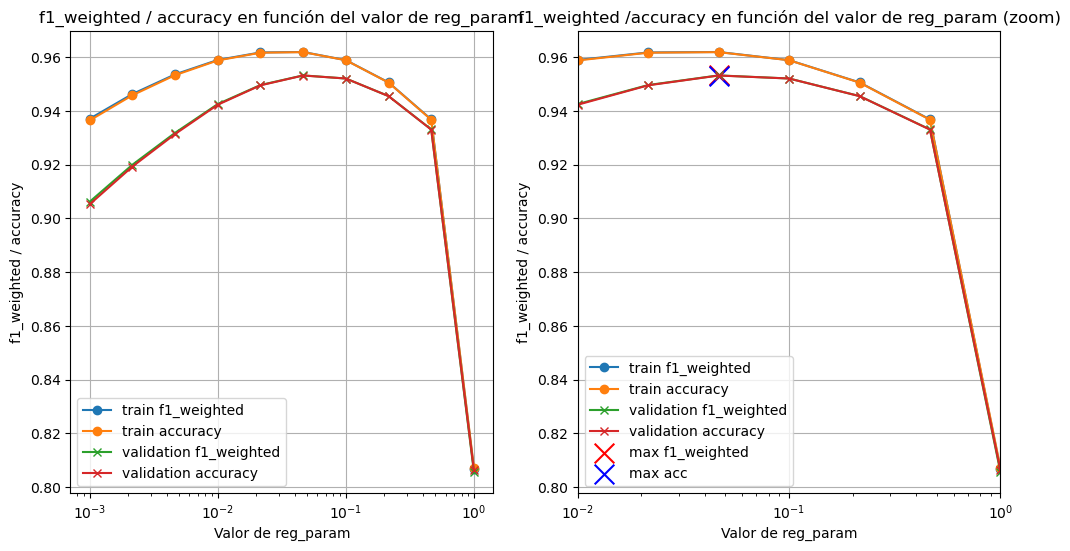

Valor de reg_param que maximiza el f1_weighted score: 0.046415888336127774
f1_weighted máximo: 0.9531437631761372
Valor de reg_param que maximiza el accuracy: 0.046415888336127774
accuracy máximo: 0.9531000000000001


In [41]:
# Mostramos la evolución de las métricas en función del valor de reg_param
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(reg_param_values, train_f1, label="train f1_weighted", marker='o')
ax[0].plot(reg_param_values, train_acc, label="train accuracy", marker='o')
ax[0].plot(reg_param_values, val_f1, label="validation f1_weighted", marker='x')
ax[0].plot(reg_param_values, val_acc, label="validation accuracy", marker='x')
ax[0].set_xlabel("Valor de reg_param")
ax[0].set_xscale("log")
ax[0].set_ylabel("f1_weighted / accuracy")
ax[0].set_title("f1_weighted / accuracy en función del valor de reg_param")
ax[0].legend()
ax[0].grid()

# Ahora mostraremos un zoom en la zona donde se encuentra el mínimo
ax[1].plot(reg_param_values, train_f1, label="train f1_weighted", marker='o')
ax[1].plot(reg_param_values, train_acc, label="train accuracy", marker='o')
ax[1].plot(reg_param_values, val_f1, label="validation f1_weighted", marker='x')
ax[1].plot(reg_param_values, val_acc, label="validation accuracy", marker='x')
ax[1].scatter(reg_param_values[np.argmax(val_f1)], max(val_f1), c='red', marker='x', label='max f1_weighted', s=200)
ax[1].scatter(reg_param_values[np.argmax(val_acc)], max(val_acc), c='blue', marker='x', label='max acc', s=200)
ax[1].set_xlabel("Valor de reg_param")
ax[1].set_xscale("log")
ax[1].set_ylabel("f1_weighted / accuracy")
ax[1].set_title("f1_weighted /accuracy en función del valor de reg_param (zoom)")
ax[1].legend()
ax[1].grid()
ax[1].set_xlim(1e-2, 1)
# ax[1].set_ylim(0.8, 1)
plt.show()

print("Valor de reg_param que maximiza el f1_weighted score:", reg_param_values[np.argmax(val_f1)])
print("f1_weighted máximo:", max(val_f1))
print("Valor de reg_param que maximiza el accuracy:", reg_param_values[np.argmax(val_acc)])
print("accuracy máximo:", max(val_acc))

### 3.5 Entrenamiento del mejor modelo

c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,QuadraticDiscriminantAnalysis(best_reg_param),0.960333,0.960395,18.941726,QuadraticDiscriminantAnalysis(reg_param=0.0464...,0.9577,0.957705


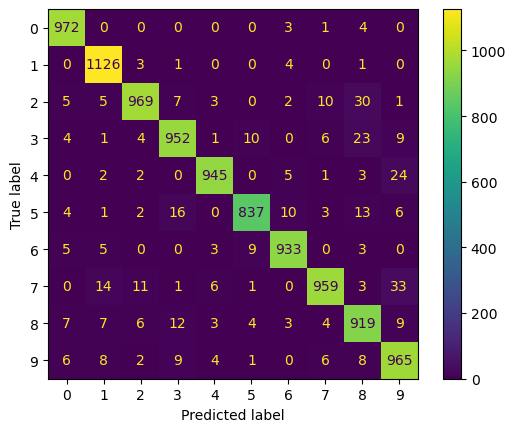

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      0.99      0.98      1135
           2       0.97      0.94      0.95      1032
           3       0.95      0.94      0.95      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.94      0.95       892
           6       0.97      0.97      0.97       958
           7       0.97      0.93      0.95      1028
           8       0.91      0.94      0.93       974
           9       0.92      0.96      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



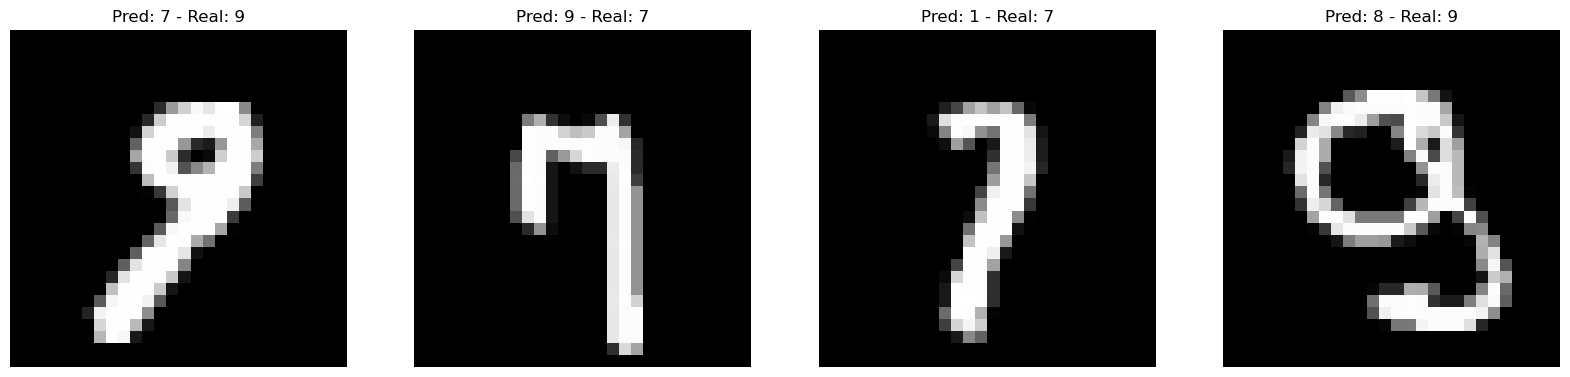

In [51]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# Entrenamos el modelo con mejor lambda
clf = QuadraticDiscriminantAnalysis(reg_param=reg_param_values[np.argmax(val_acc)], store_covariance=True) # store_covariance=True para que se guarden las matrices de covarianzas

t1 = time.time()
clf.fit(X_train, y_train)
t2 = time.time()

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

addMetricsToResults("QuadraticDiscriminantAnalysis(best_reg_param)", y_train, y_train_pred, y_test, y_test_pred, clf, t2 - t1)
show_confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

show_fails(y_test, y_test_pred, X_test)

In [43]:
results

,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,GaussianNB(default),0.564900,0.529334,1.841578,GaussianNB(),0.5558,0.517042
1,GaussianNB(priors=[0.10]*10),0.564900,0.529346,2.215322,"GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0....",0.5558,0.517075
2,GaussianNB(best_var_smoothing),0.801333,0.801512,0.503757,"GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0....",0.8141,0.814061
3,LinearDiscriminantAnalysis(default),0.871483,0.871465,3.360857,LinearDiscriminantAnalysis(),0.8730,0.872678
4,"LinearDiscriminantAnalysis(lsqr, shrinkage='au...",0.875483,0.875476,2.014574,"LinearDiscriminantAnalysis(shrinkage='auto', s...",0.8781,0.877792
5,"LinearDiscriminantAnalysis(lsqr,best_shrinkage)",0.874883,0.874858,0.951229,LinearDiscriminantAnalysis(shrinkage=0.2782559...,0.8793,0.879036
6,"LinearDiscriminantAnalysis(lsqr, ShrunkCovaria...",0.873567,0.873501,2.032893,LinearDiscriminantAnalysis(covariance_estimato...,0.8765,0.876186
7,QuadraticDiscriminantAnalysis(default),0.552500,0.490568,4.150234,QuadraticDiscriminantAnalysis(),0.5260,0.458334
8,QuadraticDiscriminantAnalysis(best_reg_param),0.960333,0.960395,3.765320,QuadraticDiscriminantAnalysis(reg_param=0.0464...,0.9577,0.957705


Se ha conseguido mejorar minimamente el modelo anterior poniendo el valor de regularización que mejor resultado a dado en lugar de dejarlo en 'auto'.

### 3.6. Estudio de la matriz de covarianza

[array([[ 4.64158883e-02,  8.80914265e-20, -3.11708125e-19, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 8.13151629e-20,  4.64158883e-02,  1.23599048e-17, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.98155597e-19,  1.12757026e-17,  4.64158883e-02, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          4.64158883e-02,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  4.64158883e-02,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  4.64158883e-02]]),
 array([[ 4.64158883e-02,  2.16840434e-19,  1.08420217e-19, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.16840434e-19,  4.64158883e-02, -5.09575021e-18, ...,
          0.00000000e+00,  0.00000000e

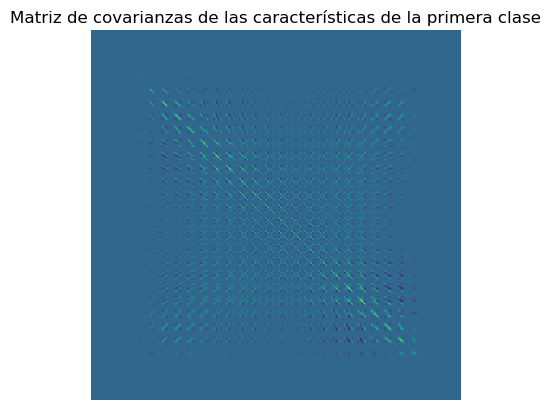

In [58]:
# A continuación estudiaremos la matriz de covarianzas de las características de la primera clase
# del modelo con mejor reg_param
# En clf.covariance_ se almacenan las matrices de covarianzas de las características de cada clase

display(clf.covariance_)

# Mostramos la matriz de covarianzas de las características de la primera clase
plt.figure()
plt.imshow(clf.covariance_[0])
plt.title("Matriz de covarianzas de las características de la primera clase")
plt.axis('off')
plt.show()

Se observa como los píxeles guardan una mayor correlación con los píxeles anexos. Esto tiene sentido ya que si un píxel es blanco es probable que los píxeles anexos también lo sean.

### 3.7 Discusión de resultados

In [60]:
display(resultsCov)
results

,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,"LinearDiscriminantAnalysis(lsqr, EmpiricalCova...",0.871483,0.871465,1.963125,LinearDiscriminantAnalysis(covariance_estimato...,0.8730,0.872678
1,"LinearDiscriminantAnalysis(lsqr, LedoitWolf)",0.871417,0.871388,2.452855,LinearDiscriminantAnalysis(covariance_estimato...,0.8741,0.873810
2,"LinearDiscriminantAnalysis(lsqr, OAS)",0.871400,0.871371,2.013280,LinearDiscriminantAnalysis(covariance_estimato...,0.8741,0.873810
3,"LinearDiscriminantAnalysis(lsqr, ShrunkCovaria...",0.873567,0.873501,2.023452,LinearDiscriminantAnalysis(covariance_estimato...,0.8765,0.876186


,Label,accuracy_train,f1_train,train_time,model,accuracy_test,f1_test
0,GaussianNB(default),0.564900,0.529334,1.841578,GaussianNB(),0.5558,0.517042
1,GaussianNB(priors=[0.10]*10),0.564900,0.529346,2.215322,"GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0....",0.5558,0.517075
2,GaussianNB(best_var_smoothing),0.801333,0.801512,0.503757,"GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0....",0.8141,0.814061
3,LinearDiscriminantAnalysis(default),0.871483,0.871465,3.360857,LinearDiscriminantAnalysis(),0.8730,0.872678
4,"LinearDiscriminantAnalysis(lsqr, shrinkage='au...",0.875483,0.875476,2.014574,"LinearDiscriminantAnalysis(shrinkage='auto', s...",0.8781,0.877792
5,"LinearDiscriminantAnalysis(lsqr,best_shrinkage)",0.874883,0.874858,0.951229,LinearDiscriminantAnalysis(shrinkage=0.2782559...,0.8793,0.879036
6,"LinearDiscriminantAnalysis(lsqr, ShrunkCovaria...",0.873567,0.873501,2.032893,LinearDiscriminantAnalysis(covariance_estimato...,0.8765,0.876186
7,QuadraticDiscriminantAnalysis(default),0.552500,0.490568,4.150234,QuadraticDiscriminantAnalysis(),0.5260,0.458334
8,QuadraticDiscriminantAnalysis(best_reg_param),0.960333,0.960395,3.765320,QuadraticDiscriminantAnalysis(reg_param=0.0464...,0.9577,0.957705


Podemos concluir que el modelo de QDA, Bayes completo, es el mejor modelo de los tres probados. Esto se debe a que asume que cada clase tiene su propia matriz de covarianza, lo que es más general que los otros dos modelos. El modelo de LDA es el segundo mejor modelo, ya que asume que todas las clases comparten la misma matriz de covarianza, lo que no es cierto, pero es mejor que el modelo de Bayes ingenuo, que asume que todas las características son independientes entre ellas, lo que no es cierto.

Además se ha observado que la regularización resulta muy útil en Bayes ingenuo y QDA, ya que este sin regularización igual que bayes ingenuo, pero no tanto para LDAs, ya que este modelo por defecto ya es bastante bueno y mejora muy poco con la regularización.

Por otro lado han probado modelos que utilizaban distintos estimadores de covarianza, sin embargo, no se ha observado una mejora en el desempeño de los modelos. Es posible que ajustando los parámetros de estos fuese posible mejorar el desempeño de los modelos, sin embargo no se dispone de la experiencia necesaria para hacerlo en este momento.

## 5. Comparación de la estimación Bayesiana con la regresión logística y redes neuronales

Resultados práctica 4, regresión lineal, regresión logística y redes neuronales:

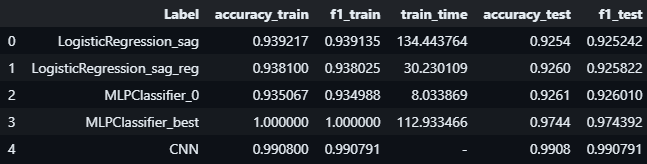

Resultados actuales, clasificación bayesiana:

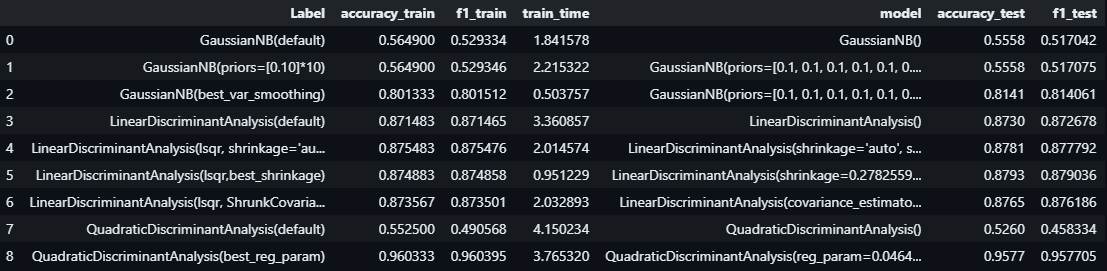

En cuanto al bayes ingenuo, no hay mucho que decir, parte de la premisa errónea de que los datos son independientes entre ellos, por lo que no es un buen modelo para MNIST. En cuanto a LDA y QDA, estos modelos son más generales que la regresión logística, ya que asumen que las clases tienen una matriz de covarianza compartida o distinta respectivamente, lo que es más realista que la regresión logística, que no hace esta suposición. Además, se ha observado que la regularización es muy útil en Bayes ingenuo y QDA, ya que estos modelos sin regularización no son muy buenos, mientras que LDA no mejora mucho con la regularización.

LDA y regresión logística se parecen porque ambos son modelos lineales, sin embargo, LDA es un modelo más general que la regresión logística, ya que asume que todas las clases comparten la misma matriz de covarianza, mientras que la regresión logística no hace esta suposición que no es correcta. Esto hace que la regresión logística tenga un mejor desempeño que LDA.

Por otro lado, QDA realiza la suposición de que cada clase tiene su propia matriz de covarianza, lo que es más general que los otros dos modelos, por lo que tiene un mejor desempeño que estos. En la regresión logística no se hizo expansión de atributos por lo que esta no tiene en cuenta la relación entre los píxeles, mientras que QDA lo hace de forma implícita.
Esta expansión no se hizo en la regresión logística porque no se disponía de la capacidad computacional necesaria para hacerlo pero si que tenia sentido hacerla para mejorar el modelo captando la relación entre los píxeles.

En cuanto a las redes neuronales, son la mejor aproximación para este dataset ya que aprenden relaciones no lineales entre los datos y no hacen ninguna suposición sobre estos.
